# Notebook F: Temporary Playground



### Load imports

In [1]:
import cobra
import pandas as pd

import sys
source_dir = '../src'
sys.path.append(source_dir)

from gsm_bounds_from_biomass_cutoff.add_gsm_bounds_from_cutoff import add_gsm_bounds_from_cutoff
from gsm_bounds_from_biomass_cutoff.get_gsm_df_from_cutoff import get_gsm_df_from_cutoff
from plotting.plot_flux_map import plot_flux_map

### Load the genome scale model

In [2]:
model = cobra.io.json.load_json_model('../genome_scale_models/iYLI647_corr_3.json')

### Rename some reactions to remove parentheses
This is because parentheses in reaction ids cause problems with StrainDesign

In [3]:
model.reactions.get_by_id('EX_glc(e)').id = 'EX_glc_e'
model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# print an example reaction
model.reactions.get_by_id('EX_glc_e')

Reaction identifier,EX_glc_e
Name,D Glucose exchange
Memory address,0x2df65ee30
Stoichiometry,glc_D[e] <=> D_Glucose <=>
GPR,YALI0D01111g or YALI0D18876g or YALI0D00132g or YALI0B01342g or YALI0E23287g or YALI0B00396g or...
Lower bound,-10.0
Upper bound,1000.0


### Load <sup>13</sup>C-MFA data

In [4]:
central_rxn_df = pd.read_excel('../data/13c_mfa/Full MFA data 01192024.xlsx', sheet_name='Full MFA Data 01192024')

# calculate the number of reactions in the 13C MFA that are mapped to the GSM
mapped_rxn_df = central_rxn_df.dropna(subset = ["reaction_ids"])

print(f'There are {len(mapped_rxn_df)} reactions in the 13C MFA that are mapped to the GSM')

central_rxn_df.head()

There are 46 reactions in the 13C MFA that are mapped to the GSM


,Pathway,ID,Equation,reaction_ids,Location on map,Glucose MFA Flux,Glucose MFA LB,Glucose MFA UB,Glycerol MFA Flux,Glycerol MFA LB,Glycerol MFA UB,Oleic Acid MFA Flux,Oleic Acid MFA LB,Oleic Acid MFA UB
0,uptake,gluc uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,"(-1180, 1175)",100.0000,100.000,100.0000,NaN,NaN,NaN,NaN,NaN,NaN
1,uptake,glyc uptake,Glycerol -> GLYC,reverse_GLYCt,"(-1376, 417)",NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN
2,uptake,R3.2,GLYC + ATP -> DHAP + 1.5*ATP,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 8*NADH + 12*ATP,OCDCEAt,"(-55, 111)",NaN,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.000
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,"(-1180, 960)",18.0175,9.792,23.5403,-41.3947,-41.5761,-36.5906,-305.8491,-319.0201,-256.517


### Load growth parameters 

In [5]:
# load the growth parameters from a csv
growth_parameters_df = pd.read_csv('../results/growth_parameters/growth_parameters.csv')
growth_parameters_df.set_index('Unnamed: 0', inplace=True)

growth_parameters_df

,glucose,glycerol,oleic_acid
Unnamed: 0,,,
growth_rate,0.266298,0.358041,0.260555
growth_rate_std,0.003048,0.000861,0.012321
yield_coefficient,0.110433,0.058610,0.341479
yield_coefficient_std,0.003913,0.009653,0.029548
substrate_uptake_rate,2.414362,6.266590,0.763019
substrate_uptake_rate_std,0.088704,0.959634,0.075240


# Glucose

### Get biomass cutoff from observed yield coefficient

In [6]:
# Get glucose yield coefficient and standard deviation
glucose_yield_coefficient = growth_parameters_df.loc['yield_coefficient', 'glucose']
glucose_yield_coefficient_std = growth_parameters_df.loc['yield_coefficient_std', 'glucose']

glucose_biomass_cutoff = glucose_yield_coefficient - 2 * glucose_yield_coefficient_std
print(f'glucose biomass cutoff: {glucose_biomass_cutoff} g biomass per mmol glucose')


glucose biomass cutoff: 0.102607311105205 g biomass per mmol glucose


### Add GSM bounds that are compatible with minimum biomass flux using FVA

In [7]:
central_rxn_df = add_gsm_bounds_from_cutoff(
    model = model,
    central_rxn_df = central_rxn_df,
    substrate = 'Glucose',
    uptake_reaction = 'EX_glc_e',
    biomass_cutoff = 100 * glucose_biomass_cutoff
)

central_rxn_df.head(6)

-EX_glc_e >= 100.0, -EX_glc_e <= 100.0, biomass_glucose >= 10.260731110520501, biomass_oil = 0, biomass_C = 0, biomass_N = 0


,Pathway,ID,Equation,reaction_ids,Location on map,Glucose MFA Flux,Glucose MFA LB,Glucose MFA UB,Glycerol MFA Flux,Glycerol MFA LB,Glycerol MFA UB,Oleic Acid MFA Flux,Oleic Acid MFA LB,Oleic Acid MFA UB,Glucose GSM LB,Glucose GSM UB,Glucose_mfa_bound_feasibility
0,uptake,gluc uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,"(-1180, 1175)",100.0000,100.0000,100.0000,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,fully feasible
1,uptake,glyc uptake,Glycerol -> GLYC,reverse_GLYCt,"(-1376, 417)",NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN,-26.574563,-0.0,
2,uptake,R3.2,GLYC + ATP -> DHAP + 1.5*ATP,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.0000,NaN,NaN,NaN,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 8*NADH + 12*ATP,OCDCEAt,"(-55, 111)",NaN,NaN,NaN,NaN,NaN,NaN,100.0000,100.0000,100.0000,0.0,-0.0,
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,"(-1180, 960)",18.0175,9.7920,23.5403,-41.3947,-41.5761,-36.5906,-305.8491,-319.0201,-256.5170,-190.412199,92.008809,fully feasible
5,glycolysis/gluconeogensis,R5 net,F6P + ATP <-> FBP,PFK or reverse_FBP,"(-1180, 700)",56.7218,53.3756,59.0811,-20.6531,-20.7135,-19.0518,-144.5891,-148.9667,-128.1481,-336.832582,82.770173,fully feasible


### Generate GSM bounds from the biomass cutoff for glucose

In [8]:
glucose_gsm_df_from_cutoff = get_gsm_df_from_cutoff(
    model=model, 
    central_rxn_df=central_rxn_df,
    substrate='Glucose',
    uptake_reaction = 'EX_glc_e',
    biomass_cutoff = 100 * glucose_biomass_cutoff
)

# save the dataframe to a csv file
glucose_gsm_df_from_cutoff.to_csv('../results/gsm_fluxes/glucose_biomass_bound_gsm_fluxes.csv', index=False)

glucose_gsm_df_from_cutoff.head()


-EX_glc_e >= 100.0, -EX_glc_e <= 100.0, biomass_glucose >= 10.260731110520501, biomass_oil = 0, biomass_C = 0, biomass_N = 0


,reaction_id,reaction_name,full_reaction,Glucose Biomass-Constrained GSM flux,Glucose Biomass-Constrained GSM LB,Glucose Biomass-Constrained GSM UB
0,13BGH,Endo 1 3 beta glucan glucohydrase,13BDglcn[c] + h2o[c] --> glc_D[c],0.000000,0.000000,168.416291
1,13BGHe,Exo 1 3 beta glucan glucohydrase,13BDglcn[e] + h2o[e] --> glc_D[e],0.000000,0.000000,-0.000000
2,ASADi,aspartate semialdehyde dehydrogenase irreversible,4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...,4.309997,3.461022,87.519866
3,2DDA7Ptm,2 Dehydro 3 deoxy D arabino heptonate7 phohsph...,2dda7p[c] <=> 2dda7p[m],-1.572623,-34.450654,-0.000000
4,2DHPtm,2 Dehydropantoate mitochondrial transport,2dhp[c] <=> 2dhp[m],0.000000,0.000000,11.090159


### Plot flux map with bounds from biomass cutoff

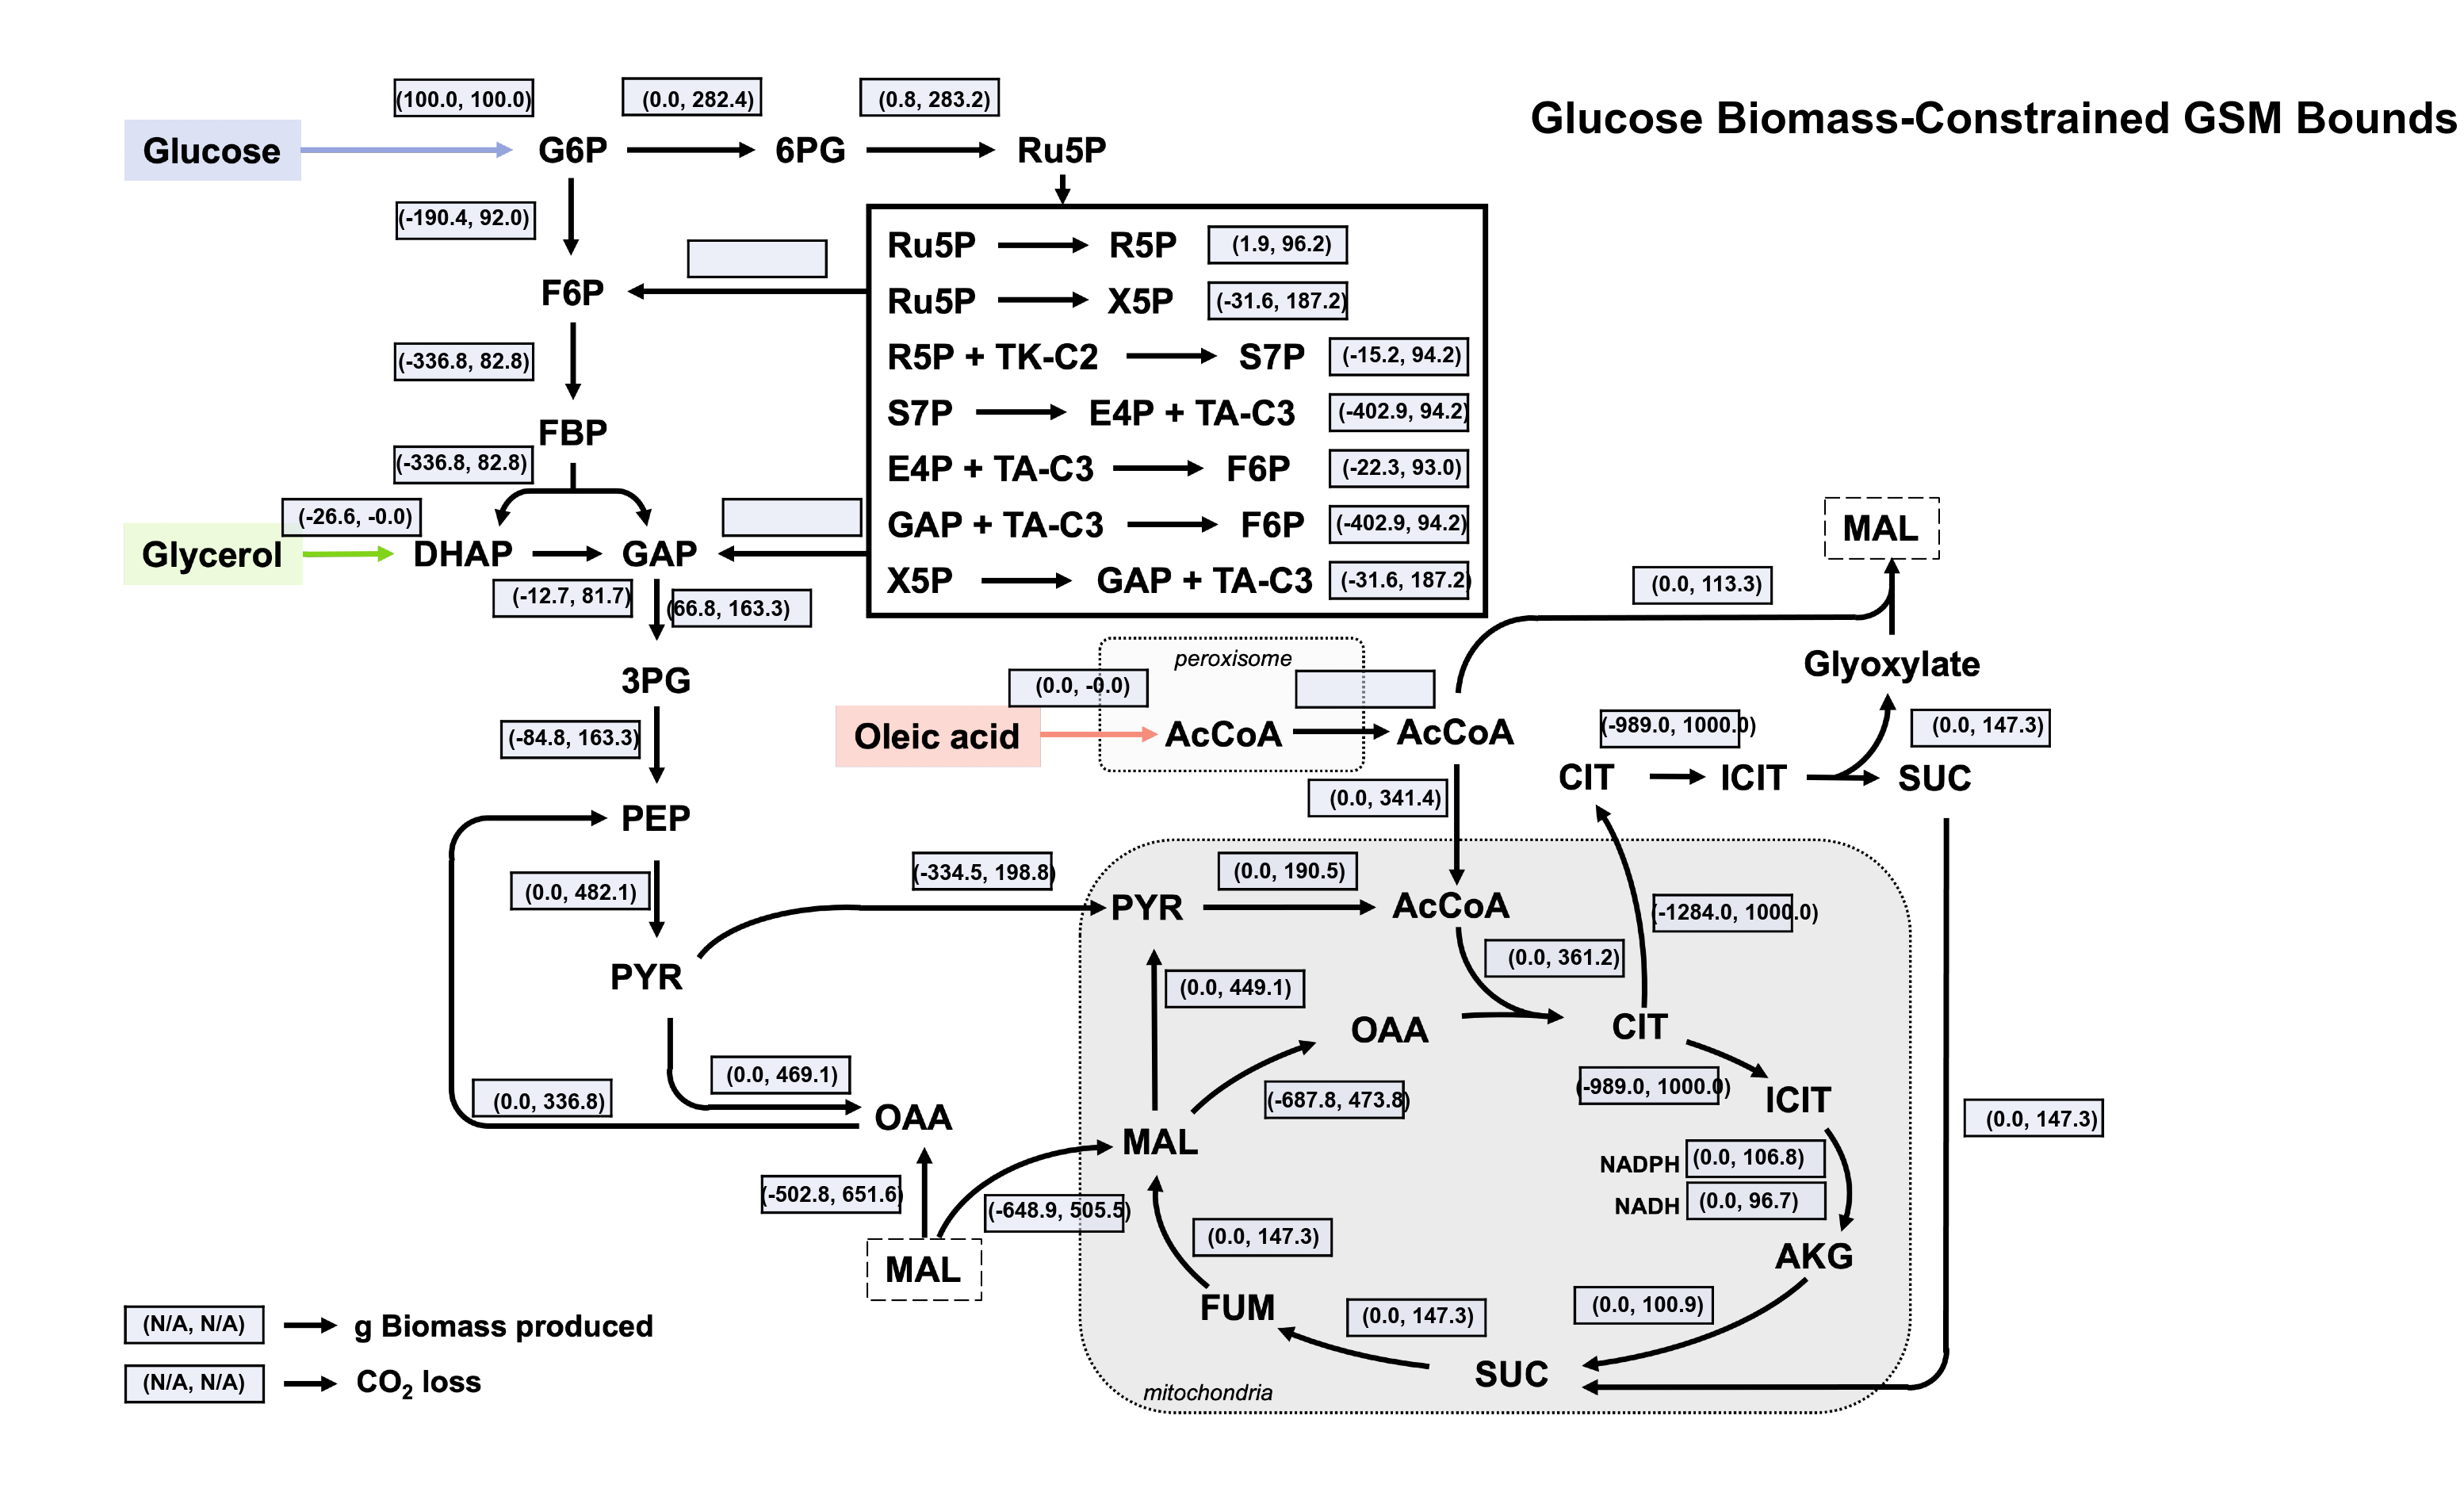

In [9]:
glucose_mfa_map = plot_flux_map(
    flux_df=central_rxn_df, 
    flux_column=['Glucose GSM LB', 'Glucose GSM UB'],
    title_string='Glucose Biomass-Constrained GSM Bounds',
    file_name='../figures/Glucose Biomass-Constrained GSM Bounds.png',
)

## Glycerol

### Get biomass cutoff from observed yield coefficient

In [10]:
# Get glycerol yield coefficient
glycerol_yield_coefficient = growth_parameters_df.loc['yield_coefficient', 'glycerol']
glycerol_yield_coefficient_std = growth_parameters_df.loc['yield_coefficient_std', 'glycerol']

glycerol_biomass_cutoff = glycerol_yield_coefficient - 2 * glycerol_yield_coefficient_std
print(f'glycerol biomass cutoff: {glycerol_biomass_cutoff} g biomass per mmol glycerol')


glycerol biomass cutoff: 0.039303800604366904 g biomass per mmol glycerol


### Add GSM bounds that are compatible with minimum biomass flux using FVA

In [27]:
central_rxn_df = add_gsm_bounds_from_cutoff(
    model = model,
    central_rxn_df = central_rxn_df,
    substrate = 'Glycerol',
    uptake_reaction = 'EX_glyc_e',
    biomass_cutoff = 100 * glycerol_biomass_cutoff
)

central_rxn_df.head(49)

-EX_glyc_e >= 100.0, -EX_glyc_e <= 100.0, biomass_glucose >= 3.9303800604366903, biomass_oil = 0, biomass_C = 0, biomass_N = 0


,Pathway,ID,Equation,reaction_ids,Location on map,Glucose MFA Flux,Glucose MFA LB,Glucose MFA UB,Glycerol MFA Flux,Glycerol MFA LB,Glycerol MFA UB,Oleic Acid MFA Flux,Oleic Acid MFA LB,Oleic Acid MFA UB,Glucose GSM LB,Glucose GSM UB,Glucose_mfa_bound_feasibility,Glycerol GSM LB,Glycerol GSM UB,Glycerol_mfa_bound_feasibility
0,uptake,gluc uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,"(-1180, 1175)",100.0000,100.0000,100.0000,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,fully feasible,0.0,-0.0,
1,uptake,glyc uptake,Glycerol -> GLYC,reverse_GLYCt,"(-1376, 417)",NaN,NaN,NaN,1.000000e+02,100.0000,100.0000,NaN,NaN,NaN,-26.574563,-0.0,,100.0,100.0,fully feasible
2,uptake,R3.2,GLYC + ATP -> DHAP + 1.5*ATP,NaN,NaN,NaN,NaN,NaN,1.000000e+02,100.0000,100.0000,NaN,NaN,NaN,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 8*NADH + 12*ATP,OCDCEAt,"(-55, 111)",NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+02,100.0000,100.0000,0.0,-0.0,,0.0,-0.0,
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,"(-1180, 960)",18.0175,9.7920,23.5403,-4.139470e+01,-41.5761,-36.5906,-3.058491e+02,-319.0201,-256.5170,-190.412199,92.008809,fully feasible,-96.832349,-3.061031,fully feasible
5,glycolysis/gluconeogensis,R5 net,F6P + ATP <-> FBP,PFK or reverse_FBP,"(-1180, 700)",56.7218,53.3756,59.0811,-2.065310e+01,-20.7135,-19.0518,-1.445891e+02,-148.9667,-128.1481,-336.832582,82.770173,fully feasible,-177.118595,-6.599897,fully feasible
6,glycolysis/gluconeogensis,R6 net,FBP <-> DHAP + GAP,FBA,"(-1184, 515)",56.7218,53.3756,59.0811,-2.065310e+01,-20.7135,-19.0518,-1.445891e+02,-148.9667,-128.1481,-336.832582,82.770173,fully feasible,-177.118595,-6.599897,fully feasible
7,glycolysis/gluconeogensis,R7 net,DHAP <-> GAP,TPI,"(-984, 273)",55.2244,51.7849,57.7445,7.870330e+01,78.6429,80.3046,-1.528556e+02,-157.2308,-136.4145,-12.701671,81.688971,fully feasible,58.393819,92.985948,fully feasible
8,glycolysis/gluconeogensis,R8 net,GAP <-> G3P + ATP + NADH,GAPD,"(-700, 250)",130.1644,125.2820,135.6607,6.793370e+01,67.8732,69.5346,-2.186947e+02,-223.0502,-202.2536,66.84424,163.326714,fully feasible,51.250847,85.952273,fully feasible
9,glycolysis/gluconeogensis,R9 net,G3P <-> PEP,ENO,"(-980, 15)",125.4818,120.3684,131.5478,6.638970e+01,66.3727,67.9837,-2.240012e+02,-224.3677,-206.2233,-84.753206,163.326714,fully feasible,-45.790398,85.952273,fully feasible


### Generate GSM bounds from the biomass cutoff for glycerol

In [22]:
glycerol_gsm_df_from_cutoff = get_gsm_df_from_cutoff(
    model=model, 
    central_rxn_df=central_rxn_df,
    substrate='Glycerol',
    uptake_reaction = 'EX_glyc_e',
    biomass_cutoff = 100 * glycerol_biomass_cutoff
)

# save the dataframe to a csv file
glycerol_gsm_df_from_cutoff.to_csv('../results/gsm_fluxes/glycerol_biomass_bound_gsm_fluxes.csv', index=False)

glycerol_gsm_df_from_cutoff.head()

glycerol_df = glycerol_gsm_df_from_cutoff.copy()

glycerol_df

-EX_glyc_e >= 100.0, -EX_glyc_e <= 100.0, biomass_glucose >= 3.9303800604366903, biomass_oil = 0, biomass_C = 0, biomass_N = 0


,reaction_id,reaction_name,full_reaction,Glycerol Biomass-Constrained GSM flux,Glycerol Biomass-Constrained GSM LB,Glycerol Biomass-Constrained GSM UB
0,13BGH,Endo 1 3 beta glucan glucohydrase,13BDglcn[c] + h2o[c] --> glc_D[c],0.000000,0.000000,82.709275
1,13BGHe,Exo 1 3 beta glucan glucohydrase,13BDglcn[e] + h2o[e] --> glc_D[e],0.000000,0.000000,-0.000000
2,ASADi,aspartate semialdehyde dehydrogenase irreversible,4pasp[c] + h[c] + nadph[c] --> aspsa[c] + nadp...,1.783335,1.325747,45.437360
3,2DDA7Ptm,2 Dehydro 3 deoxy D arabino heptonate7 phohsph...,2dda7p[c] <=> 2dda7p[m],0.000000,-15.199105,-0.000000
4,2DHPtm,2 Dehydropantoate mitochondrial transport,2dhp[c] <=> 2dhp[m],0.000000,0.000000,5.384212
...,...,...,...,...,...,...
1346,EX_eryth(e),EX_eryth(e),erythritol[e] -->,0.000000,0.000000,17.106089
1347,EX_biom,EX_biom,biomass[c] -->,5.286971,3.930380,5.286971
1348,MALS,Malate synthase,accoa[c] + glx[c] + h2o[c] --> coa[c] + h[c] +...,0.000000,0.000000,61.471600
1349,biomass_glucose,,0.6822317267700153 13BDglcn[c] + 0.55472655920...,5.286971,3.930380,5.286971


In [13]:
# a function to get the reaction ids of all the reactions for a metabolite from its id
def get_reaction_ids_from_metabolite_id(metabolite_id):
    reaction_ids = []
    for reaction in model.metabolites.get_by_id(metabolite_id).reactions:
        reaction_ids.append(reaction.id)
    return reaction_ids

get_reaction_ids_from_metabolite_id('acrn[m]')

['CSNATirm', 'CSNATifm', 'CRNCARtm', 'ACRNtm']

In [14]:
# get list of carnitine reactions
for r in model.reactions:
    if 'acrn[m]' in r.reaction:
        print(r.id, r.reaction)


ACRNtm acrn[c] --> acrn[m]
CRNCARtm acrn[c] + crn[m] --> acrn[m] + crn[c]
CSNATifm acrn[m] + coa[m] --> accoa[m] + crn[m]
CSNATirm accoa[m] + crn[m] --> acrn[m] + coa[m]


In [23]:
glycerol_df[glycerol_df['reaction_id'].isin(get_reaction_ids_from_metabolite_id('acrn[m]'))]

,reaction_id,reaction_name,full_reaction,Glycerol Biomass-Constrained GSM flux,Glycerol Biomass-Constrained GSM LB,Glycerol Biomass-Constrained GSM UB
67,ACRNtm,O acetylcarnintine transport into mitochondria...,acrn[c] --> acrn[m],0.000000,0.0,1000.000000
249,CRNCARtm,carnithine acetylcarnithine carrier mitochondrial,acrn[c] + crn[m] <=> acrn[m] + crn[c],-18.665692,-1000.0,143.397367
255,CSNATifm,carnitine O aceyltransferase forward reaction ...,acrn[m] + coa[m] --> accoa[m] + crn[m],0.000000,0.0,1000.000000
256,CSNATirm,carnitine O acetyltransferase reverse directio...,accoa[m] + crn[m] --> acrn[m] + coa[m],18.665692,0.0,1000.000000


In [24]:
glycerol_df[glycerol_df['reaction_id'].isin(get_reaction_ids_from_metabolite_id('acrn[c]'))]

,reaction_id,reaction_name,full_reaction,Glycerol Biomass-Constrained GSM flux,Glycerol Biomass-Constrained GSM LB,Glycerol Biomass-Constrained GSM UB
67,ACRNtm,O acetylcarnintine transport into mitochondria...,acrn[c] --> acrn[m],0.000000,0.000000,1000.000000
68,ACRNtp,acetylcarnitine transport out of peroxisome,acrn[x] --> acrn[c],0.000000,0.000000,48.120283
249,CRNCARtm,carnithine acetylcarnithine carrier mitochondrial,acrn[c] + crn[m] <=> acrn[m] + crn[c],-18.665692,-1000.000000,143.397367
250,CRNCARtp,carnitine acetylcarnitine carrier peroxisomal,acrn[x] + crn[c] --> acrn[c] + crn[x],0.000000,0.000000,48.120283
254,CSNAT,carnitine O acetyltransferase,accoa[c] + crn[c] <=> acrn[c] + coa[c],-18.665692,-81.455654,143.397367


In [25]:
glycerol_df[glycerol_df['reaction_id'].isin(get_reaction_ids_from_metabolite_id('crn[m]'))]

,reaction_id,reaction_name,full_reaction,Glycerol Biomass-Constrained GSM flux,Glycerol Biomass-Constrained GSM LB,Glycerol Biomass-Constrained GSM UB
249,CRNCARtm,carnithine acetylcarnithine carrier mitochondrial,acrn[c] + crn[m] <=> acrn[m] + crn[c],-18.665692,-1000.0,143.397367
252,CRNtim,L carnitine transport out of mitochondria via ...,crn[m] --> crn[c],0.000000,0.0,1000.000000
255,CSNATifm,carnitine O aceyltransferase forward reaction ...,acrn[m] + coa[m] --> accoa[m] + crn[m],0.000000,0.0,1000.000000
256,CSNATirm,carnitine O acetyltransferase reverse directio...,accoa[m] + crn[m] --> acrn[m] + coa[m],18.665692,0.0,1000.000000


In [26]:
glycerol_df[glycerol_df['reaction_id'].isin(get_reaction_ids_from_metabolite_id('crn[c]'))]

,reaction_id,reaction_name,full_reaction,Glycerol Biomass-Constrained GSM flux,Glycerol Biomass-Constrained GSM LB,Glycerol Biomass-Constrained GSM UB
249,CRNCARtm,carnithine acetylcarnithine carrier mitochondrial,acrn[c] + crn[m] <=> acrn[m] + crn[c],-18.665692,-1000.000000,143.397367
250,CRNCARtp,carnitine acetylcarnitine carrier peroxisomal,acrn[x] + crn[c] --> acrn[c] + crn[x],0.000000,0.000000,48.120283
251,CRNt,L carnitine reversible transport,crn[e] <=> crn[c],0.000000,0.000000,-0.000000
252,CRNtim,L carnitine transport out of mitochondria via ...,crn[m] --> crn[c],0.000000,0.000000,1000.000000
253,CRNtp,carnitine transport into peroxsiome,crn[c] --> crn[x],0.000000,0.000000,48.120283
254,CSNAT,carnitine O acetyltransferase,accoa[c] + crn[c] <=> acrn[c] + coa[c],-18.665692,-81.455654,143.397367


In [19]:
acrn_m_reactions = get_reaction_ids_from_metabolite_id('acrn[m]')
acrn_c_reactions = get_reaction_ids_from_metabolite_id('acrn[c]')
crn_m_reactions = get_reaction_ids_from_metabolite_id('crn[m]')
crn_c_reactions = get_reaction_ids_from_metabolite_id('crn[c]')

carnitine_reactions = acrn_m_reactions + acrn_c_reactions + crn_m_reactions + crn_c_reactions

carnitine_reactions

['CSNATirm',
 'CSNATifm',
 'CRNCARtm',
 'ACRNtm',
 'CSNAT',
 'ACRNtp',
 'CRNCARtp',
 'ACRNtm',
 'CRNCARtm',
 'CSNATirm',
 'CSNATifm',
 'CRNtim',
 'CRNCARtm',
 'CRNt',
 'CRNtp',
 'CSNAT',
 'CRNCARtp',
 'CRNtim',
 'CRNCARtm']

In [20]:
# for r in carnitine_reactions:
#     model.reactions.get_by_id(r).bounds = (-1000, 1000)
#     print(model.reactions.get_by_id(r).bounds)

In [21]:
model.reactions.get_by_id('CRNCARtm').bounds = (-1000, 1000)
model.reactions.get_by_id('CSNAT').bounds = (-1000, 1000)

In [28]:
model.reactions.get_by_id('CRNCARtm')

Reaction identifier,CRNCARtm
Name,carnithine acetylcarnithine carrier mitochondrial
Memory address,0x2df5ae5f0
Stoichiometry,acrn[c] + crn[m] <=> acrn[m] + crn[c] O_Acetylcarnitine + L_Carnitine <=> O_Acetylcarnitine + L_Carnitine
GPR,YALI0C02431g
Lower bound,-1000
Upper bound,1000


In [29]:
model.reactions.get_by_id('CSNAT')

Reaction identifier,CSNAT
Name,carnitine O acetyltransferase
Memory address,0x2df5aeb30
Stoichiometry,accoa[c] + crn[c] <=> acrn[c] + coa[c] Acetyl_CoA + L_Carnitine <=> O_Acetylcarnitine + Coenzyme_A
GPR,
Lower bound,-1000
Upper bound,1000


In [4]:
nums = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[num ** 2 for num in nums]

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

### Plot flux map with bounds from biomass cutoff

In [ ]:
glycerol_mfa_map = plot_flux_map(
    flux_df=central_rxn_df, 
    flux_column=['Glycerol GSM LB', 'Glycerol GSM UB'],
    title_string='Glycerol Biomass-Constrained GSM Bounds',
    file_name='../figures/Glycerol Biomass-Constrained GSM Bounds.png',
)

# Oleic Acid

### Get biomass cutoff from observed yield coefficient

In [ ]:
# Get oleic_acid yield coefficient
oleic_acid_yield_coefficient = growth_parameters_df.loc['yield_coefficient', 'oleic_acid']
oleic_acid_yield_coefficient_std = growth_parameters_df.loc['yield_coefficient_std', 'oleic_acid']

oleic_acid_biomass_cutoff = oleic_acid_yield_coefficient - 2 * oleic_acid_yield_coefficient_std
print(f'oleic_acid biomass cutoff: {oleic_acid_biomass_cutoff} g biomass per mmol oleic_acid')


### Add GSM bounds that are compatible with minimum biomass flux using FVA

In [ ]:
central_rxn_df = add_gsm_bounds_from_cutoff(
    model = model,
    central_rxn_df = central_rxn_df,
    substrate = 'Oleic Acid',
    uptake_reaction = 'EX_ocdcea_e',
    biomass_cutoff = 10 * oleic_acid_biomass_cutoff
)

central_rxn_df

### Generate GSM bounds from the biomass cutoff for oleic acid

In [ ]:
oleic_acid_gsm_df_from_cutoff = get_gsm_df_from_cutoff(
    model=model, 
    central_rxn_df=central_rxn_df,
    substrate='Oleic Acid',
    uptake_reaction = 'EX_ocdcea_e',
    biomass_cutoff = 10 * oleic_acid_biomass_cutoff
)

# save the dataframe to a csv file
oleic_acid_gsm_df_from_cutoff.to_csv('../results/gsm_fluxes/oleic_acid_biomass_bound_gsm_fluxes.csv', index=False)

oleic_acid_gsm_df_from_cutoff.head()

### Plot flux map with bounds from biomass cutoff

In [ ]:
oleic_acid_mfa_map = plot_flux_map(
    flux_df=central_rxn_df, 
    flux_column=['Oleic Acid GSM LB', 'Oleic Acid GSM UB'],
    title_string='Oleic Acid Biomass-Constrained GSM Bounds',
    file_name='../figures/Oleic Acid Biomass-Constrained GSM Bounds.png',
)

## Save the GSM bounds so they can be used to constrain the GSM

In [ ]:
# save the central_rxn_df
central_rxn_df.to_csv('../results/central_fluxes/mfa_bounds_from_gsm.csv')